# Lab 10: Diffie-Hellman Key Exchange and Man-in-the-Middle Attack

**Objective:** Simulate the Diffie-Hellman key exchange protocol in Python and demonstrate how a Man-in-the-Middle (MITM) attack can intercept and manipulate the shared keys.

---

## Introduction

The **Diffie-Hellman key exchange** is one of the earliest practical implementations of public-key cryptography. It allows two parties to establish a shared secret key over an insecure channel without having to exchange the key directly.

However, the basic Diffie-Hellman protocol is vulnerable to a **Man-in-the-Middle (MITM) attack**, where an attacker can intercept the communication between two parties and establish separate shared keys with each of them.

In this lab, we will:
1. Implement the standard Diffie-Hellman key exchange
2. Simulate a MITM attack with three entities: Alice, Bob, and Tom (the attacker)
3. Visualize how the attack works and its consequences

## Part 1: Understanding Diffie-Hellman Key Exchange

### How it works:

The Diffie-Hellman protocol uses the following steps:

1. **Public Parameters:** Both parties agree on two public numbers:
   - A large prime number `p`
   - A primitive root (generator) `g` modulo `p`

2. **Private Keys:** Each party generates their own private key:
   - Alice chooses a random private key `a`
   - Bob chooses a random private key `b`

3. **Public Keys:** Each party computes their public key:
   - Alice computes: $A = g^a \mod p$
   - Bob computes: $B = g^b \mod p$

4. **Key Exchange:** They exchange their public keys over the insecure channel.

5. **Shared Secret:** Each party computes the shared secret:
   - Alice computes: $S = B^a \mod p = g^{ab} \mod p$
   - Bob computes: $S = A^b \mod p = g^{ab} \mod p$

Both arrive at the same shared secret without ever transmitting it!

### Importing Required Libraries

We'll need `random` for generating private keys and `matplotlib` for visualizing the attack.

In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# Setting a seed for reproducibility (you can remove this for truly random behavior)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Part 2: Implementing the Diffie-Hellman Protocol

First, let's create a simple class that represents a participant in the Diffie-Hellman key exchange. Each participant will have:
- A name for identification
- A private key (kept secret)
- A public key (shared openly)
- The ability to compute a shared secret with another party's public key

In [2]:
class DHParticipant:
    """
    A class representing a participant in the Diffie-Hellman key exchange.
    
    Each participant has:
    - name: identifier for the participant
    - private_key: a secret random number
    - public_key: computed from the private key
    """
    
    def __init__(self, name, prime, generator):
        self.name = name
        self.p = prime        # the public prime number
        self.g = generator    # the public generator
        
        # Generate a random private key between 2 and p-2
        # We avoid 1 and p-1 for security reasons
        self.private_key = random.randint(2, self.p - 2)
        
        # Calculate the public key using modular exponentiation
        # public_key = g^private_key mod p
        self.public_key = pow(self.g, self.private_key, self.p)
        
    def compute_shared_secret(self, other_public_key):
        """
        Compute the shared secret using the other party's public key.
        
        shared_secret = other_public_key^private_key mod p
        """
        shared_secret = pow(other_public_key, self.private_key, self.p)
        return shared_secret
    
    def get_info(self):
        """Return a dictionary with the participant's information."""
        return {
            'name': self.name,
            'private_key': self.private_key,
            'public_key': self.public_key
        }

print("DHParticipant class defined successfully!")

DHParticipant class defined successfully!


## Part 3: Setting Up Public Parameters

For the Diffie-Hellman protocol to work, we need a prime number `p` and a generator `g`. In real-world applications, these numbers are very large (2048 bits or more). For demonstration purposes, we'll use smaller numbers.

**Note:** The prime `p = 23` and generator `g = 5` form a valid Diffie-Hellman group because 5 is a primitive root modulo 23.

In [3]:
# Public parameters for Diffie-Hellman
# In practice, these would be much larger numbers (2048+ bits)
# Using small numbers here for easier demonstration

PRIME = 23      # A prime number p
GENERATOR = 5   # A primitive root g modulo p

print("=" * 50)
print("DIFFIE-HELLMAN PUBLIC PARAMETERS")
print("=" * 50)
print(f"Prime (p):     {PRIME}")
print(f"Generator (g): {GENERATOR}")
print("\nThese parameters are publicly known to everyone.")
print("=" * 50)

DIFFIE-HELLMAN PUBLIC PARAMETERS
Prime (p):     23
Generator (g): 5

These parameters are publicly known to everyone.


## Part 4: Normal Key Exchange (Without Attack)

Let's first see how a normal Diffie-Hellman key exchange works between Alice and Bob when there's no attacker present. Both parties should end up with the same shared secret key.

In [4]:
# Create Alice and Bob for normal key exchange
alice_normal = DHParticipant("Alice", PRIME, GENERATOR)
bob_normal = DHParticipant("Bob", PRIME, GENERATOR)

# They exchange public keys and compute shared secrets
alice_shared_normal = alice_normal.compute_shared_secret(bob_normal.public_key)
bob_shared_normal = bob_normal.compute_shared_secret(alice_normal.public_key)

print("=" * 60)
print("NORMAL DIFFIE-HELLMAN KEY EXCHANGE")
print("=" * 60)
print("\n--- Alice's Information ---")
print(f"Private Key (secret): {alice_normal.private_key}")
print(f"Public Key:           {alice_normal.public_key}")

print("\n--- Bob's Information ---")
print(f"Private Key (secret): {bob_normal.private_key}")
print(f"Public Key:           {bob_normal.public_key}")

print("\n--- Shared Secrets ---")
print(f"Alice's computed secret: {alice_shared_normal}")
print(f"Bob's computed secret:   {bob_shared_normal}")

if alice_shared_normal == bob_shared_normal:
    print("\n✓ SUCCESS: Alice and Bob have the same shared secret!")
    print(f"  Shared Key = {alice_shared_normal}")
else:
    print("\n✗ ERROR: Something went wrong - keys don't match!")

print("=" * 60)

NORMAL DIFFIE-HELLMAN KEY EXCHANGE

--- Alice's Information ---
Private Key (secret): 5
Public Key:           20

--- Bob's Information ---
Private Key (secret): 2
Public Key:           2

--- Shared Secrets ---
Alice's computed secret: 9
Bob's computed secret:   9

✓ SUCCESS: Alice and Bob have the same shared secret!
  Shared Key = 9


### Visualizing Normal Key Exchange

Let's create a visual diagram showing how the normal key exchange works between Alice and Bob.

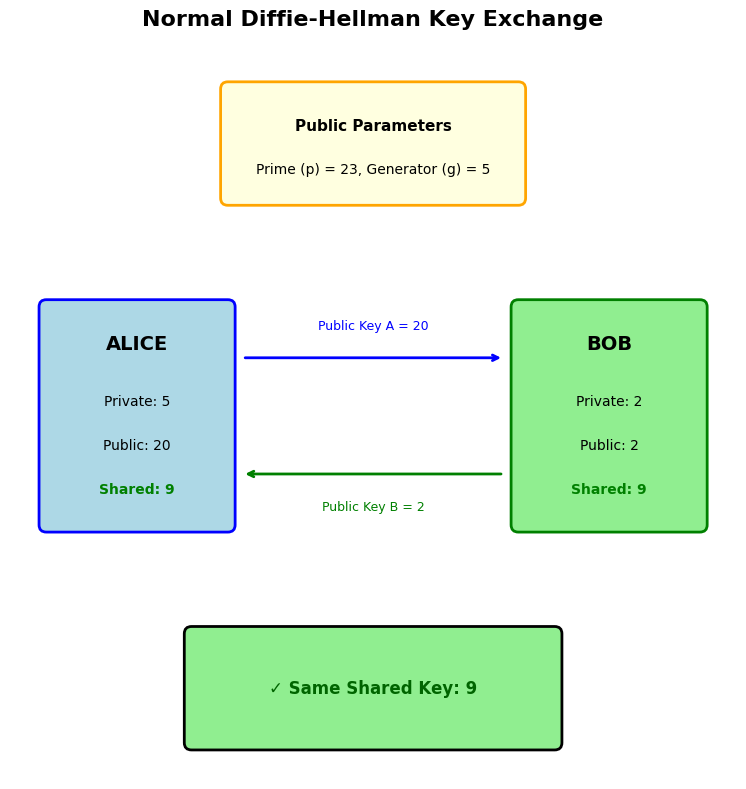

In [5]:
def visualize_normal_exchange(alice, bob, alice_secret, bob_secret):
    """
    Create a visualization of the normal Diffie-Hellman key exchange.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Normal Diffie-Hellman Key Exchange', fontsize=16, fontweight='bold', pad=20)
    
    # Draw Alice (left side)
    alice_box = FancyBboxPatch((0.5, 3.5), 2.5, 3, 
                                boxstyle="round,pad=0.1", 
                                facecolor='lightblue', edgecolor='blue', linewidth=2)
    ax.add_patch(alice_box)
    ax.text(1.75, 6, 'ALICE', ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(1.75, 5.2, f'Private: {alice.private_key}', ha='center', va='center', fontsize=10)
    ax.text(1.75, 4.6, f'Public: {alice.public_key}', ha='center', va='center', fontsize=10)
    ax.text(1.75, 4.0, f'Shared: {alice_secret}', ha='center', va='center', fontsize=10, color='green', fontweight='bold')
    
    # Draw Bob (right side)
    bob_box = FancyBboxPatch((7, 3.5), 2.5, 3, 
                              boxstyle="round,pad=0.1", 
                              facecolor='lightgreen', edgecolor='green', linewidth=2)
    ax.add_patch(bob_box)
    ax.text(8.25, 6, 'BOB', ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(8.25, 5.2, f'Private: {bob.private_key}', ha='center', va='center', fontsize=10)
    ax.text(8.25, 4.6, f'Public: {bob.public_key}', ha='center', va='center', fontsize=10)
    ax.text(8.25, 4.0, f'Shared: {bob_secret}', ha='center', va='center', fontsize=10, color='green', fontweight='bold')
    
    # Draw arrows for public key exchange
    # Alice sends public key to Bob
    ax.annotate('', xy=(6.8, 5.8), xytext=(3.2, 5.8),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))
    ax.text(5, 6.2, f'Public Key A = {alice.public_key}', ha='center', fontsize=9, color='blue')
    
    # Bob sends public key to Alice
    ax.annotate('', xy=(3.2, 4.2), xytext=(6.8, 4.2),
                arrowprops=dict(arrowstyle='->', color='green', lw=2))
    ax.text(5, 3.7, f'Public Key B = {bob.public_key}', ha='center', fontsize=9, color='green')
    
    # Add result box at bottom
    result_color = 'lightgreen' if alice_secret == bob_secret else 'lightcoral'
    result_box = FancyBboxPatch((2.5, 0.5), 5, 1.5, 
                                 boxstyle="round,pad=0.1", 
                                 facecolor=result_color, edgecolor='black', linewidth=2)
    ax.add_patch(result_box)
    
    if alice_secret == bob_secret:
        ax.text(5, 1.25, f'✓ Same Shared Key: {alice_secret}', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='darkgreen')
    else:
        ax.text(5, 1.25, '✗ Keys do not match!', ha='center', va='center', 
                fontsize=12, fontweight='bold', color='darkred')
    
    # Add public parameters box at top
    params_box = FancyBboxPatch((3, 8), 4, 1.5, 
                                 boxstyle="round,pad=0.1", 
                                 facecolor='lightyellow', edgecolor='orange', linewidth=2)
    ax.add_patch(params_box)
    ax.text(5, 9, 'Public Parameters', ha='center', va='center', fontsize=11, fontweight='bold')
    ax.text(5, 8.4, f'Prime (p) = {PRIME}, Generator (g) = {GENERATOR}', ha='center', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Visualize the normal exchange
visualize_normal_exchange(alice_normal, bob_normal, alice_shared_normal, bob_shared_normal)

## Part 5: Man-in-the-Middle Attack

### Understanding the Attack

In a **Man-in-the-Middle (MITM) attack**, an attacker (Tom) positions himself between Alice and Bob. Tom intercepts all communications between them and:

1. When Alice sends her public key to Bob, Tom intercepts it and sends his own public key to Bob instead
2. When Bob sends his public key to Alice, Tom intercepts it and sends his own public key to Alice instead

**Result:**
- Alice thinks she's communicating with Bob, but actually establishes a shared key with Tom
- Bob thinks he's communicating with Alice, but actually establishes a shared key with Tom
- Tom can decrypt messages from either party, re-encrypt them, and forward them

This is why the basic Diffie-Hellman protocol needs to be combined with authentication mechanisms!

In [6]:
# Reset random seed for new participants
random.seed(123)

# Create three participants: Alice, Bob, and Tom (the attacker)
alice = DHParticipant("Alice", PRIME, GENERATOR)
bob = DHParticipant("Bob", PRIME, GENERATOR)
tom = DHParticipant("Tom (Attacker)", PRIME, GENERATOR)

print("=" * 60)
print("ENTITIES IN THE MITM ATTACK SCENARIO")
print("=" * 60)

print("\n--- Alice (Legitimate User) ---")
print(f"Private Key: {alice.private_key}")
print(f"Public Key:  {alice.public_key}")

print("\n--- Bob (Legitimate User) ---")
print(f"Private Key: {bob.private_key}")
print(f"Public Key:  {bob.public_key}")

print("\n--- Tom (The Attacker) ---")
print(f"Private Key: {tom.private_key}")
print(f"Public Key:  {tom.public_key}")

print("=" * 60)

ENTITIES IN THE MITM ATTACK SCENARIO

--- Alice (Legitimate User) ---
Private Key: 3
Public Key:  10

--- Bob (Legitimate User) ---
Private Key: 10
Public Key:  9

--- Tom (The Attacker) ---
Private Key: 4
Public Key:  4


### Simulating the Attack

Now let's simulate what happens when Tom intercepts and manipulates the key exchange:

1. Alice tries to send her public key to Bob → Tom intercepts it
2. Tom sends his own public key to Bob (pretending to be Alice)
3. Bob tries to send his public key to Alice → Tom intercepts it
4. Tom sends his own public key to Alice (pretending to be Bob)

Each party computes their shared secret using the public key they received (which is actually Tom's public key!).

In [7]:
# Simulating the MITM attack
print("=" * 70)
print("SIMULATING MAN-IN-THE-MIDDLE ATTACK")
print("=" * 70)

# Step 1: Alice computes her shared secret using what she thinks is Bob's public key
# But actually, she receives Tom's public key!
print("\n[STEP 1] Alice tries to send her public key to Bob...")
print(f"         Alice's public key: {alice.public_key}")
print("         >>> Tom INTERCEPTS the message! <<<")

print("\n[STEP 2] Tom sends HIS public key to Bob, pretending to be Alice...")
print(f"         Tom sends public key: {tom.public_key} (to Bob)")

print("\n[STEP 3] Bob tries to send his public key to Alice...")
print(f"         Bob's public key: {bob.public_key}")
print("         >>> Tom INTERCEPTS the message! <<<")

print("\n[STEP 4] Tom sends HIS public key to Alice, pretending to be Bob...")
print(f"         Tom sends public key: {tom.public_key} (to Alice)")

# Now each party computes their "shared" secret
# Alice uses Tom's public key (thinking it's Bob's)
alice_shared = alice.compute_shared_secret(tom.public_key)

# Bob uses Tom's public key (thinking it's Alice's)
bob_shared = bob.compute_shared_secret(tom.public_key)

# Tom computes two shared secrets - one with Alice, one with Bob
tom_alice_shared = tom.compute_shared_secret(alice.public_key)
tom_bob_shared = tom.compute_shared_secret(bob.public_key)

print("\n" + "=" * 70)
print("COMPUTED SHARED SECRETS")
print("=" * 70)

SIMULATING MAN-IN-THE-MIDDLE ATTACK

[STEP 1] Alice tries to send her public key to Bob...
         Alice's public key: 10
         >>> Tom INTERCEPTS the message! <<<

[STEP 2] Tom sends HIS public key to Bob, pretending to be Alice...
         Tom sends public key: 4 (to Bob)

[STEP 3] Bob tries to send his public key to Alice...
         Bob's public key: 9
         >>> Tom INTERCEPTS the message! <<<

[STEP 4] Tom sends HIS public key to Alice, pretending to be Bob...
         Tom sends public key: 4 (to Alice)

COMPUTED SHARED SECRETS


### Analyzing the Results of the Attack

Let's now carefully examine what each party ended up with and verify that:
1. Alice's shared key matches Tom's key with Alice
2. Bob's shared key matches Tom's key with Bob
3. Alice and Bob do NOT have the same shared key

In [8]:
print("\n" + "=" * 70)
print("ATTACK RESULTS ANALYSIS")
print("=" * 70)

print("\n--- Alice's Perspective ---")
print(f"Alice thinks she shares a key with Bob.")
print(f"Alice's computed shared key: {alice_shared}")

print("\n--- Bob's Perspective ---")
print(f"Bob thinks he shares a key with Alice.")
print(f"Bob's computed shared key: {bob_shared}")

print("\n--- Tom's Perspective (The Attacker) ---")
print(f"Tom knows BOTH keys!")
print(f"Tom's shared key with Alice: {tom_alice_shared}")
print(f"Tom's shared key with Bob:   {tom_bob_shared}")

print("\n" + "=" * 70)
print("VERIFICATION")
print("=" * 70)

# Verification 1: Alice shares a secret key with Tom
print("\n[CHECK 1] Does Alice share a key with Tom?")
if alice_shared == tom_alice_shared:
    print(f"  ✓ YES! Alice's key ({alice_shared}) = Tom's key with Alice ({tom_alice_shared})")
else:
    print(f"  ✗ NO! Keys don't match")

# Verification 2: Bob shares a different secret key with Tom
print("\n[CHECK 2] Does Bob share a key with Tom?")
if bob_shared == tom_bob_shared:
    print(f"  ✓ YES! Bob's key ({bob_shared}) = Tom's key with Bob ({tom_bob_shared})")
else:
    print(f"  ✗ NO! Keys don't match")

# Verification 3: Alice and Bob do NOT share the same key
print("\n[CHECK 3] Do Alice and Bob share the same key?")
if alice_shared != bob_shared:
    print(f"  ✓ CORRECT! They have DIFFERENT keys!")
    print(f"     Alice's key: {alice_shared}")
    print(f"     Bob's key:   {bob_shared}")
    print(f"  >>> The MITM attack is SUCCESSFUL! <<<")
else:
    print(f"  ✗ ERROR! They have the same key (attack failed)")

print("\n" + "=" * 70)


ATTACK RESULTS ANALYSIS

--- Alice's Perspective ---
Alice thinks she shares a key with Bob.
Alice's computed shared key: 18

--- Bob's Perspective ---
Bob thinks he shares a key with Alice.
Bob's computed shared key: 6

--- Tom's Perspective (The Attacker) ---
Tom knows BOTH keys!
Tom's shared key with Alice: 18
Tom's shared key with Bob:   6

VERIFICATION

[CHECK 1] Does Alice share a key with Tom?
  ✓ YES! Alice's key (18) = Tom's key with Alice (18)

[CHECK 2] Does Bob share a key with Tom?
  ✓ YES! Bob's key (6) = Tom's key with Bob (6)

[CHECK 3] Do Alice and Bob share the same key?
  ✓ CORRECT! They have DIFFERENT keys!
     Alice's key: 18
     Bob's key:   6
  >>> The MITM attack is SUCCESSFUL! <<<



### Visualizing the Man-in-the-Middle Attack

Let's create a comprehensive visualization showing how Tom intercepts and manipulates the communication between Alice and Bob.

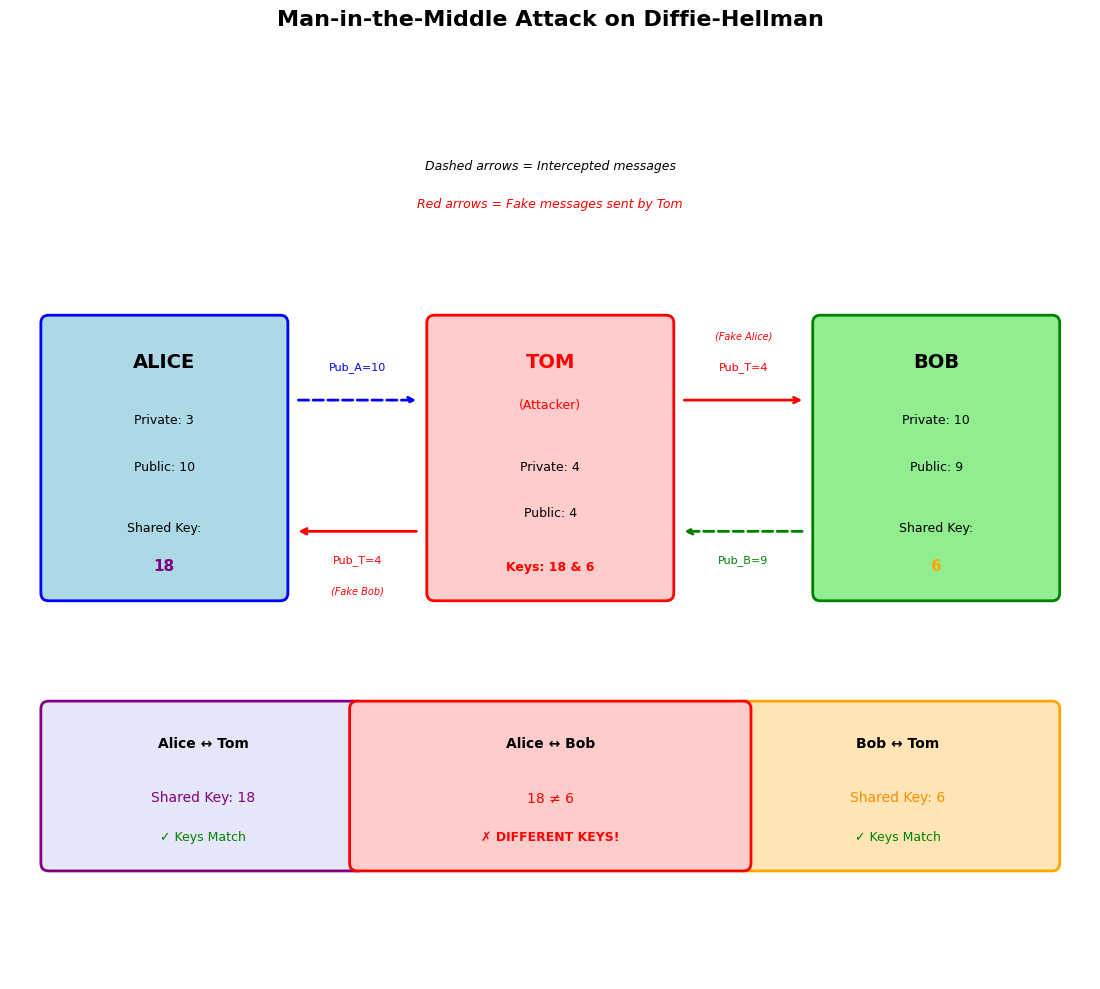

In [9]:
def visualize_mitm_attack(alice, bob, tom, alice_shared, bob_shared, tom_alice, tom_bob):
    """
    Create a detailed visualization of the Man-in-the-Middle attack.
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 12)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Man-in-the-Middle Attack on Diffie-Hellman', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Draw Alice (left side)
    alice_box = FancyBboxPatch((0.5, 5), 3, 3.5, 
                                boxstyle="round,pad=0.1", 
                                facecolor='lightblue', edgecolor='blue', linewidth=2)
    ax.add_patch(alice_box)
    ax.text(2, 8, 'ALICE', ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(2, 7.2, f'Private: {alice.private_key}', ha='center', fontsize=9)
    ax.text(2, 6.6, f'Public: {alice.public_key}', ha='center', fontsize=9)
    ax.text(2, 5.8, f'Shared Key:', ha='center', fontsize=9)
    ax.text(2, 5.3, f'{alice_shared}', ha='center', fontsize=11, color='purple', fontweight='bold')
    
    # Draw Bob (right side)
    bob_box = FancyBboxPatch((10.5, 5), 3, 3.5, 
                              boxstyle="round,pad=0.1", 
                              facecolor='lightgreen', edgecolor='green', linewidth=2)
    ax.add_patch(bob_box)
    ax.text(12, 8, 'BOB', ha='center', va='center', fontsize=14, fontweight='bold')
    ax.text(12, 7.2, f'Private: {bob.private_key}', ha='center', fontsize=9)
    ax.text(12, 6.6, f'Public: {bob.public_key}', ha='center', fontsize=9)
    ax.text(12, 5.8, f'Shared Key:', ha='center', fontsize=9)
    ax.text(12, 5.3, f'{bob_shared}', ha='center', fontsize=11, color='orange', fontweight='bold')
    
    # Draw Tom (center - the attacker)
    tom_box = FancyBboxPatch((5.5, 5), 3, 3.5, 
                              boxstyle="round,pad=0.1", 
                              facecolor='#ffcccc', edgecolor='red', linewidth=2)
    ax.add_patch(tom_box)
    ax.text(7, 8, 'TOM', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
    ax.text(7, 7.4, '(Attacker)', ha='center', fontsize=9, color='red')
    ax.text(7, 6.6, f'Private: {tom.private_key}', ha='center', fontsize=9)
    ax.text(7, 6.0, f'Public: {tom.public_key}', ha='center', fontsize=9)
    ax.text(7, 5.3, f'Keys: {tom_alice} & {tom_bob}', ha='center', fontsize=9, color='red', fontweight='bold')
    
    # Draw intercepted arrows (Alice to Tom)
    ax.annotate('', xy=(5.3, 7.5), xytext=(3.7, 7.5),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2, linestyle='--'))
    ax.text(4.5, 7.9, f'Pub_A={alice.public_key}', ha='center', fontsize=8, color='blue')
    
    # Tom sends his key to Bob (pretending to be Alice)
    ax.annotate('', xy=(10.3, 7.5), xytext=(8.7, 7.5),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax.text(9.5, 7.9, f'Pub_T={tom.public_key}', ha='center', fontsize=8, color='red')
    ax.text(9.5, 8.3, '(Fake Alice)', ha='center', fontsize=7, color='red', style='italic')
    
    # Draw intercepted arrows (Bob to Tom)
    ax.annotate('', xy=(8.7, 5.8), xytext=(10.3, 5.8),
                arrowprops=dict(arrowstyle='->', color='green', lw=2, linestyle='--'))
    ax.text(9.5, 5.4, f'Pub_B={bob.public_key}', ha='center', fontsize=8, color='green')
    
    # Tom sends his key to Alice (pretending to be Bob)
    ax.annotate('', xy=(3.7, 5.8), xytext=(5.3, 5.8),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax.text(4.5, 5.4, f'Pub_T={tom.public_key}', ha='center', fontsize=8, color='red')
    ax.text(4.5, 5.0, '(Fake Bob)', ha='center', fontsize=7, color='red', style='italic')
    
    # Add result boxes at bottom
    # Alice-Tom shared key
    box1 = FancyBboxPatch((0.5, 1.5), 4, 2, 
                           boxstyle="round,pad=0.1", 
                           facecolor='#e6e6fa', edgecolor='purple', linewidth=2)
    ax.add_patch(box1)
    ax.text(2.5, 3, 'Alice ↔ Tom', ha='center', fontsize=10, fontweight='bold')
    ax.text(2.5, 2.3, f'Shared Key: {tom_alice}', ha='center', fontsize=10, color='purple')
    ax.text(2.5, 1.8, '✓ Keys Match', ha='center', fontsize=9, color='green')
    
    # Bob-Tom shared key
    box2 = FancyBboxPatch((9.5, 1.5), 4, 2, 
                           boxstyle="round,pad=0.1", 
                           facecolor='#ffe4b5', edgecolor='orange', linewidth=2)
    ax.add_patch(box2)
    ax.text(11.5, 3, 'Bob ↔ Tom', ha='center', fontsize=10, fontweight='bold')
    ax.text(11.5, 2.3, f'Shared Key: {tom_bob}', ha='center', fontsize=10, color='darkorange')
    ax.text(11.5, 1.8, '✓ Keys Match', ha='center', fontsize=9, color='green')
    
    # Alice-Bob comparison
    box3 = FancyBboxPatch((4.5, 1.5), 5, 2, 
                           boxstyle="round,pad=0.1", 
                           facecolor='#ffcccc', edgecolor='red', linewidth=2)
    ax.add_patch(box3)
    ax.text(7, 3, 'Alice ↔ Bob', ha='center', fontsize=10, fontweight='bold')
    ax.text(7, 2.3, f'{alice_shared} ≠ {bob_shared}', ha='center', fontsize=10, color='red')
    ax.text(7, 1.8, '✗ DIFFERENT KEYS!', ha='center', fontsize=9, color='red', fontweight='bold')
    
    # Add legend/explanation
    ax.text(7, 10.5, 'Dashed arrows = Intercepted messages', ha='center', fontsize=9, style='italic')
    ax.text(7, 10, 'Red arrows = Fake messages sent by Tom', ha='center', fontsize=9, style='italic', color='red')
    
    plt.tight_layout()
    plt.show()

# Visualize the MITM attack
visualize_mitm_attack(alice, bob, tom, alice_shared, bob_shared, tom_alice_shared, tom_bob_shared)

## Part 6: Summary Comparison

Let's create a final comparison showing the difference between a normal key exchange and one with a MITM attack.

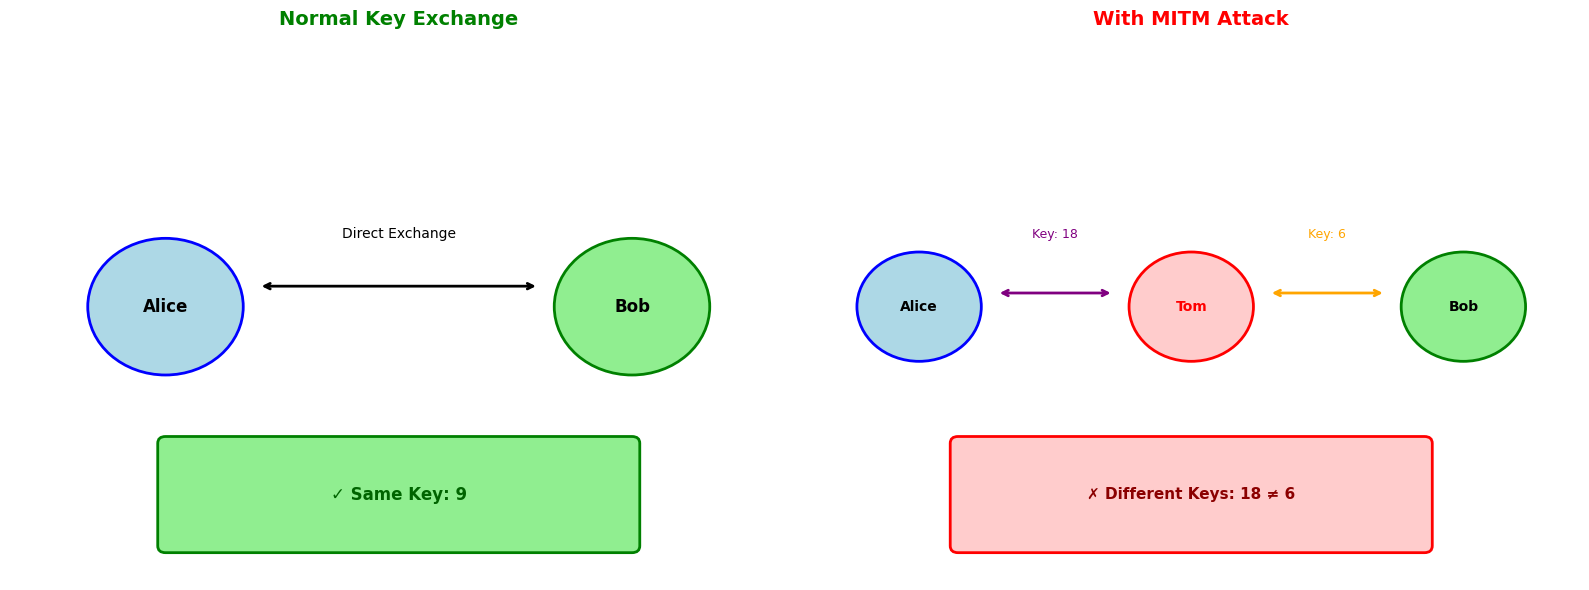

In [10]:
# Create a summary visualization comparing both scenarios
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Normal exchange
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 8)
ax1.axis('off')
ax1.set_title('Normal Key Exchange', fontsize=14, fontweight='bold', color='green')

# Draw simple diagram for normal exchange
alice_circle = plt.Circle((2, 4), 1, color='lightblue', ec='blue', linewidth=2)
bob_circle = plt.Circle((8, 4), 1, color='lightgreen', ec='green', linewidth=2)
ax1.add_patch(alice_circle)
ax1.add_patch(bob_circle)
ax1.text(2, 4, 'Alice', ha='center', va='center', fontsize=12, fontweight='bold')
ax1.text(8, 4, 'Bob', ha='center', va='center', fontsize=12, fontweight='bold')

# Arrow between them
ax1.annotate('', xy=(6.8, 4.3), xytext=(3.2, 4.3),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax1.text(5, 5, 'Direct Exchange', ha='center', fontsize=10)

# Result
result_box = FancyBboxPatch((2, 0.5), 6, 1.5, 
                             boxstyle="round,pad=0.1", 
                             facecolor='lightgreen', edgecolor='green', linewidth=2)
ax1.add_patch(result_box)
ax1.text(5, 1.25, f'✓ Same Key: {alice_shared_normal}', ha='center', va='center', 
        fontsize=12, fontweight='bold', color='darkgreen')

# MITM attack
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 8)
ax2.axis('off')
ax2.set_title('With MITM Attack', fontsize=14, fontweight='bold', color='red')

# Draw diagram for MITM attack
alice_circle2 = plt.Circle((1.5, 4), 0.8, color='lightblue', ec='blue', linewidth=2)
tom_circle = plt.Circle((5, 4), 0.8, color='#ffcccc', ec='red', linewidth=2)
bob_circle2 = plt.Circle((8.5, 4), 0.8, color='lightgreen', ec='green', linewidth=2)
ax2.add_patch(alice_circle2)
ax2.add_patch(tom_circle)
ax2.add_patch(bob_circle2)
ax2.text(1.5, 4, 'Alice', ha='center', va='center', fontsize=10, fontweight='bold')
ax2.text(5, 4, 'Tom', ha='center', va='center', fontsize=10, fontweight='bold', color='red')
ax2.text(8.5, 4, 'Bob', ha='center', va='center', fontsize=10, fontweight='bold')

# Arrows showing intercepted communication
ax2.annotate('', xy=(4, 4.2), xytext=(2.5, 4.2),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax2.annotate('', xy=(7.5, 4.2), xytext=(6, 4.2),
            arrowprops=dict(arrowstyle='<->', color='orange', lw=2))

ax2.text(3.25, 5, f'Key: {alice_shared}', ha='center', fontsize=9, color='purple')
ax2.text(6.75, 5, f'Key: {bob_shared}', ha='center', fontsize=9, color='orange')

# Result
result_box2 = FancyBboxPatch((2, 0.5), 6, 1.5, 
                              boxstyle="round,pad=0.1", 
                              facecolor='#ffcccc', edgecolor='red', linewidth=2)
ax2.add_patch(result_box2)
ax2.text(5, 1.25, f'✗ Different Keys: {alice_shared} ≠ {bob_shared}', ha='center', va='center', 
        fontsize=11, fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

## Part 7: Key Exchange Table Summary

Let's create a comprehensive summary table showing all the keys in the system.

In [11]:
# Create a summary table
import pandas as pd

# Data for the summary table
summary_data = {
    'Entity': ['Alice', 'Bob', 'Tom (Attacker)'],
    'Private Key': [alice.private_key, bob.private_key, tom.private_key],
    'Public Key': [alice.public_key, bob.public_key, tom.public_key],
    'Computed Shared Key': [
        f"{alice_shared} (with Tom's pub key)",
        f"{bob_shared} (with Tom's pub key)",
        f"{tom_alice_shared} (A), {tom_bob_shared} (B)"
    ]
}

df = pd.DataFrame(summary_data)
print("\n" + "=" * 75)
print("COMPLETE KEY EXCHANGE SUMMARY")
print("=" * 75)
print(f"\nPublic Parameters: p = {PRIME}, g = {GENERATOR}")
print("\n")
print(df.to_string(index=False))

print("\n" + "-" * 75)
print("KEY RELATIONSHIPS:")
print("-" * 75)
print(f"\n• Alice's key ({alice_shared}) = Tom's key with Alice ({tom_alice_shared})  →  ✓ Match")
print(f"• Bob's key ({bob_shared}) = Tom's key with Bob ({tom_bob_shared})  →  ✓ Match")
print(f"• Alice's key ({alice_shared}) ≠ Bob's key ({bob_shared})  →  ✗ NO Match (Attack Successful!)")
print("\n" + "=" * 75)


COMPLETE KEY EXCHANGE SUMMARY

Public Parameters: p = 23, g = 5


        Entity  Private Key  Public Key     Computed Shared Key
         Alice            3          10 18 (with Tom's pub key)
           Bob           10           9  6 (with Tom's pub key)
Tom (Attacker)            4           4           18 (A), 6 (B)

---------------------------------------------------------------------------
KEY RELATIONSHIPS:
---------------------------------------------------------------------------

• Alice's key (18) = Tom's key with Alice (18)  →  ✓ Match
• Bob's key (6) = Tom's key with Bob (6)  →  ✓ Match
• Alice's key (18) ≠ Bob's key (6)  →  ✗ NO Match (Attack Successful!)



## Part 8: Attack Impact Visualization

Let's visualize the impact of the attack - showing how Tom can read and modify all communications.

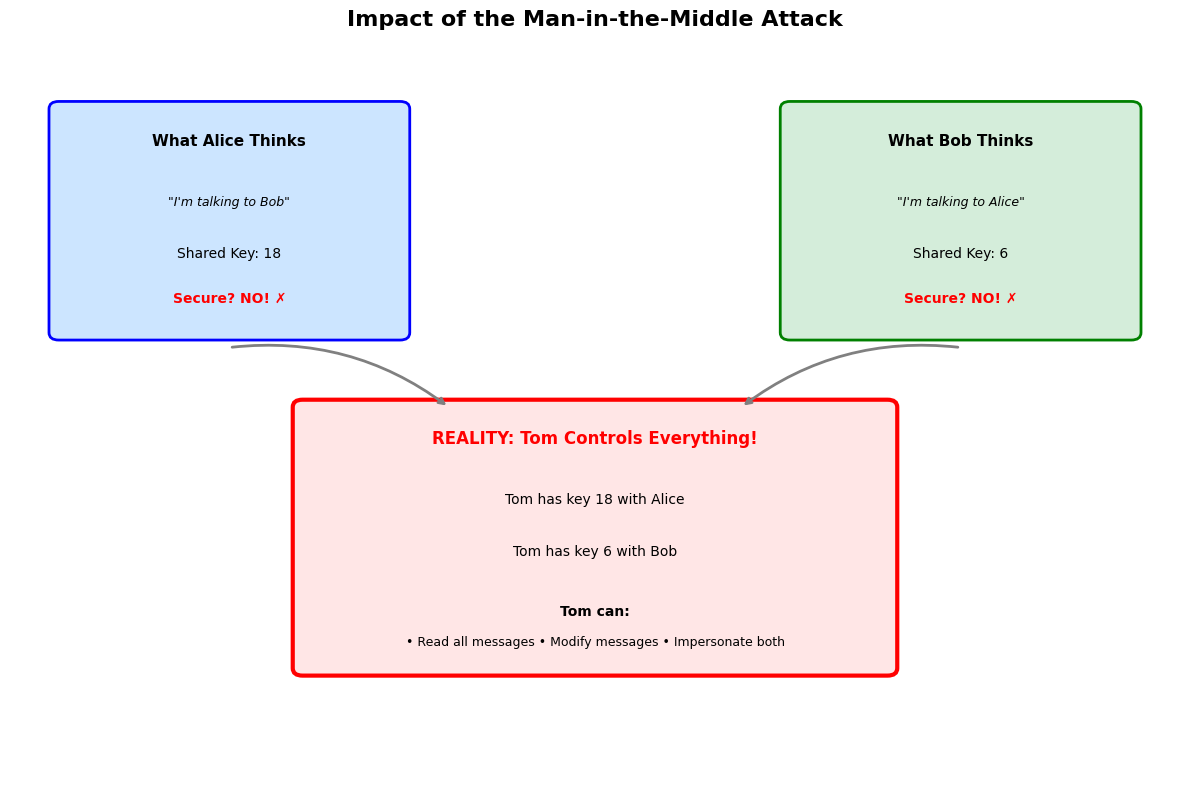

In [12]:
# Visualization showing the impact of the attack
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('Impact of the Man-in-the-Middle Attack', fontsize=16, fontweight='bold')

# Timeline representation
# Box showing what Alice thinks
alice_think = FancyBboxPatch((0.5, 6), 3.5, 3, 
                              boxstyle="round,pad=0.1", 
                              facecolor='#cce5ff', edgecolor='blue', linewidth=2)
ax.add_patch(alice_think)
ax.text(2.25, 8.5, 'What Alice Thinks', ha='center', fontsize=11, fontweight='bold')
ax.text(2.25, 7.7, '"I\'m talking to Bob"', ha='center', fontsize=9, style='italic')
ax.text(2.25, 7.0, f'Shared Key: {alice_shared}', ha='center', fontsize=10)
ax.text(2.25, 6.4, 'Secure? NO! ✗', ha='center', fontsize=10, color='red', fontweight='bold')

# Box showing what Bob thinks
bob_think = FancyBboxPatch((8, 6), 3.5, 3, 
                            boxstyle="round,pad=0.1", 
                            facecolor='#d4edda', edgecolor='green', linewidth=2)
ax.add_patch(bob_think)
ax.text(9.75, 8.5, 'What Bob Thinks', ha='center', fontsize=11, fontweight='bold')
ax.text(9.75, 7.7, '"I\'m talking to Alice"', ha='center', fontsize=9, style='italic')
ax.text(9.75, 7.0, f'Shared Key: {bob_shared}', ha='center', fontsize=10)
ax.text(9.75, 6.4, 'Secure? NO! ✗', ha='center', fontsize=10, color='red', fontweight='bold')

# Box showing reality (Tom controls everything)
reality = FancyBboxPatch((3, 1.5), 6, 3.5, 
                          boxstyle="round,pad=0.1", 
                          facecolor='#ffe6e6', edgecolor='red', linewidth=3)
ax.add_patch(reality)
ax.text(6, 4.5, 'REALITY: Tom Controls Everything!', ha='center', fontsize=12, fontweight='bold', color='red')
ax.text(6, 3.7, f'Tom has key {tom_alice_shared} with Alice', ha='center', fontsize=10)
ax.text(6, 3.0, f'Tom has key {tom_bob_shared} with Bob', ha='center', fontsize=10)
ax.text(6, 2.2, 'Tom can:', ha='center', fontsize=10, fontweight='bold')
ax.text(6, 1.8, '• Read all messages • Modify messages • Impersonate both', ha='center', fontsize=9)

# Draw arrows from Alice and Bob to reality
ax.annotate('', xy=(4.5, 5), xytext=(2.25, 5.8),
            arrowprops=dict(arrowstyle='->', color='gray', lw=2, connectionstyle="arc3,rad=-0.2"))
ax.annotate('', xy=(7.5, 5), xytext=(9.75, 5.8),
            arrowprops=dict(arrowstyle='->', color='gray', lw=2, connectionstyle="arc3,rad=0.2"))

plt.tight_layout()
plt.show()

## Conclusion

### What We Learned

1. **Diffie-Hellman Key Exchange** allows two parties to establish a shared secret over an insecure channel using:
   - Public parameters (prime `p` and generator `g`)
   - Private keys (kept secret)
   - Public keys (exchanged openly)

2. **The Vulnerability**: Basic Diffie-Hellman is susceptible to Man-in-the-Middle attacks because:
   - There's no authentication of public keys
   - An attacker can intercept and replace public keys

3. **MITM Attack Results**:
   - Alice shares key **{alice_shared}** with Tom (not Bob!)
   - Bob shares key **{bob_shared}** with Tom (not Alice!)
   - Alice and Bob have **different** keys and cannot communicate securely

### How to Prevent MITM Attacks

To prevent such attacks, we need to add **authentication** mechanisms:
- Digital signatures to verify the identity of communicating parties
- Certificate authorities (PKI - Public Key Infrastructure)
- Pre-shared secrets or passwords
- Protocols like Station-to-Station (STS) that combine DH with signatures

In [13]:
# Final summary print
print("\n" + "#" * 75)
print("#" + " " * 73 + "#")
print("#" + "          LAB 10: DIFFIE-HELLMAN & MITM ATTACK - COMPLETE          ".center(73) + "#")
print("#" + " " * 73 + "#")
print("#" * 75)

print("\nKEY FINDINGS:")
print(f"  • Alice's shared key with (fake) Bob: {alice_shared}")
print(f"  • Bob's shared key with (fake) Alice: {bob_shared}")
print(f"  • Tom's key with Alice: {tom_alice_shared}")
print(f"  • Tom's key with Bob: {tom_bob_shared}")

print("\nVERIFICATION RESULTS:")
print(f"  ✓ Alice-Tom key match: {alice_shared == tom_alice_shared}")
print(f"  ✓ Bob-Tom key match: {bob_shared == tom_bob_shared}")
print(f"  ✓ Alice-Bob keys different: {alice_shared != bob_shared}")
print(f"  ✓ MITM Attack Successful: {alice_shared != bob_shared}")

print("\n" + "#" * 75)


###########################################################################
#                                                                         #
#             LAB 10: DIFFIE-HELLMAN & MITM ATTACK - COMPLETE             #
#                                                                         #
###########################################################################

KEY FINDINGS:
  • Alice's shared key with (fake) Bob: 18
  • Bob's shared key with (fake) Alice: 6
  • Tom's key with Alice: 18
  • Tom's key with Bob: 6

VERIFICATION RESULTS:
  ✓ Alice-Tom key match: True
  ✓ Bob-Tom key match: True
  ✓ Alice-Bob keys different: True
  ✓ MITM Attack Successful: True

###########################################################################
